In [37]:
%load_ext autoreload
%autoreload 2

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv1D, Input, Dense, Add, Multiply
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers

import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from utils import crea_ventanas_all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## versiones

In [ ]:
print(tf.__version__)

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
!nvidia-smi

# Data Preparation

In [4]:
npath = 'data_out/old/'
df = pd.read_csv(npath + 'exp1.csv')
df

,_field,_value,_time,i,move,t,tt
0,a0,-0.02,2022-05-25 10:41:18.063544+00:00,1,C,0,0
1,a0,-0.02,2022-05-25 10:41:18.153125+00:00,1,C,90,90
2,a0,-0.02,2022-05-25 10:41:18.244122+00:00,1,C,181,180
3,a0,-0.02,2022-05-25 10:41:18.333530+00:00,1,C,270,270
4,a0,-0.02,2022-05-25 10:41:18.423717+00:00,1,C,360,360
...,...,...,...,...,...,...,...
72496,g2,0.02,2022-05-25 10:50:38.088343+00:00,100,A,1526,1530
72497,g2,-0.01,2022-05-25 10:50:38.177979+00:00,100,A,1616,1620
72498,g2,0.01,2022-05-25 10:50:38.313189+00:00,100,A,1751,1710
72499,g2,-0.02,2022-05-25 10:50:38.403083+00:00,100,A,1841,1800


In [8]:
dfa = df.groupby(['i', 'tt', 'move', '_field']).agg('_value').mean().reset_index()
dfp = dfa.pivot(index=['i', 'tt', 'move'], columns=['_field'], values='_value').reset_index()
dfp1 = dfp.groupby(['i']).apply(lambda group: group.interpolate())
dfp1 = dfp1.fillna(0)
dfp1['class'] = dfp1.move.astype('category').cat.codes
dfp1

_field,i,tt,move,a0,a1,a2,c0,c1,c2,f0,f1,f2,g0,g1,g2,class
0,1,-90,C,0.00,0.00,0.00,2.01,-31.65,32.90,0.00,0.00,0.00,0.0,0.00,0.00,2
1,1,0,C,-0.02,-1.00,0.00,2.12,-31.76,32.78,-1.57,0.02,-1.47,0.0,-0.01,0.00,2
2,1,90,C,-0.02,-0.99,0.00,2.11,-31.89,32.79,-1.57,0.02,-1.47,0.0,0.00,0.00,2
3,1,180,C,-0.02,-0.99,0.01,2.10,-31.72,32.78,-1.57,0.02,-1.47,0.0,0.00,0.00,2
4,1,270,C,-0.02,-0.99,0.00,1.98,-31.61,32.91,-1.57,0.02,-1.47,0.0,0.00,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6290,100,1620,A,0.00,-0.98,0.01,-2.06,-33.25,23.00,-1.60,0.00,-1.68,0.0,0.00,-0.01,0
6291,100,1710,A,0.00,-0.98,0.01,-2.09,-33.16,23.10,-1.60,0.00,-1.68,0.0,-0.01,0.01,0
6292,100,1800,A,0.00,-0.98,0.01,-2.06,-33.39,23.30,-1.60,0.00,-1.68,0.0,-0.01,-0.02,0
6293,100,1890,A,-0.03,-1.00,0.02,-1.91,-33.39,23.80,-1.60,0.00,-1.68,0.0,0.02,0.01,0


# Umap

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def standardize_function(X_train):
    df_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)

    return df_scaled


features = list(set(dfp1.columns) - set(['_field', 'i', 'tt', 'move', 'class']))

datas = standardize_function(dfp1[features])


In [ ]:
reducer = umap.UMAP(verbose=True)
embedding = reducer.fit_transform(datas)

In [ ]:
plt.figure(figsize=(20, 20))
for i, v in enumerate(['tt', 'class']):
    plt.subplot(2, 2, i + 1)
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=dfp1[v].values, s=1, alpha=1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(v, fontsize=24)

# Data Preparation 2
Cortamos en ventanas de mism tamaño

In [ ]:
# get last 58 timestamps  excluding group 100
# nlen = 56
# dfp2 = dfp1[dfp1.i != 100]
# dfp2 = dfp2.groupby("i").apply(lambda x: x.iloc[-nlen:])
# dfp2 = dfp2.rename(columns={'i': 'ii'})

In [7]:
w=10
dfp2 = crea_ventanas_all(dfp1, 'i', w)

Creamos la variable de id: i_wi

movimiento:  1
  ..creando 51 ventanas 10 frames
movimiento:  2
  ..creando 60 ventanas 10 frames
movimiento:  3
  ..creando 53 ventanas 10 frames
movimiento:  4
  ..creando 58 ventanas 10 frames
movimiento:  5
  ..creando 51 ventanas 10 frames
movimiento:  6
  ..creando 53 ventanas 10 frames
movimiento:  7
  ..creando 51 ventanas 10 frames
movimiento:  8
  ..creando 54 ventanas 10 frames
movimiento:  9
  ..creando 54 ventanas 10 frames
movimiento:  10
  ..creando 60 ventanas 10 frames
movimiento:  11
  ..creando 61 ventanas 10 frames
movimiento:  12
  ..creando 59 ventanas 10 frames
movimiento:  13
  ..creando 51 ventanas 10 frames
movimiento:  14
  ..creando 60 ventanas 10 frames
movimiento:  15
  ..creando 59 ventanas 10 frames
movimiento:  16
  ..creando 51 ventanas 10 frames
movimiento:  17
  ..creando 51 ventanas 10 frames
movimiento:  18
  ..creando 51 ventanas 10 frames
movimiento:  19
  ..creando 50 ventanas 10 frames
movimiento:  20
  ..creand

In [26]:
dfp2

_field,i,tt,move,a0,a1,a2,c0,c1,c2,f0,f1,f2,g0,g1,g2,class,frame,i_wi
0,1,-90,C,0.00,0.00,0.00,2.01,-31.65,32.90,0.00,0.00,0.00,0.0,0.00,0.00,2,1,1_1
1,1,0,C,-0.02,-1.00,0.00,2.12,-31.76,32.78,-1.57,0.02,-1.47,0.0,-0.01,0.00,2,2,1_1
2,1,90,C,-0.02,-0.99,0.00,2.11,-31.89,32.79,-1.57,0.02,-1.47,0.0,0.00,0.00,2,3,1_1
3,1,180,C,-0.02,-0.99,0.01,2.10,-31.72,32.78,-1.57,0.02,-1.47,0.0,0.00,0.00,2,4,1_1
4,1,270,C,-0.02,-0.99,0.00,1.98,-31.61,32.91,-1.57,0.02,-1.47,0.0,0.00,0.00,2,5,1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6290,100,1620,A,0.00,-0.98,0.01,-2.06,-33.25,23.00,-1.60,0.00,-1.68,0.0,0.00,-0.01,0,6,100_14
6291,100,1710,A,0.00,-0.98,0.01,-2.09,-33.16,23.10,-1.60,0.00,-1.68,0.0,-0.01,0.01,0,7,100_14
6292,100,1800,A,0.00,-0.98,0.01,-2.06,-33.39,23.30,-1.60,0.00,-1.68,0.0,-0.01,-0.02,0,8,100_14
6293,100,1890,A,-0.03,-1.00,0.02,-1.91,-33.39,23.80,-1.60,0.00,-1.68,0.0,0.02,0.01,0,9,100_14


In [27]:
dfp2=dfp2.drop(columns=['i', 'tt','move']) #aligeramos

In [28]:
dfp2

_field,a0,a1,a2,c0,c1,c2,f0,f1,f2,g0,g1,g2,class,frame,i_wi
0,0.00,0.00,0.00,2.01,-31.65,32.90,0.00,0.00,0.00,0.0,0.00,0.00,2,1,1_1
1,-0.02,-1.00,0.00,2.12,-31.76,32.78,-1.57,0.02,-1.47,0.0,-0.01,0.00,2,2,1_1
2,-0.02,-0.99,0.00,2.11,-31.89,32.79,-1.57,0.02,-1.47,0.0,0.00,0.00,2,3,1_1
3,-0.02,-0.99,0.01,2.10,-31.72,32.78,-1.57,0.02,-1.47,0.0,0.00,0.00,2,4,1_1
4,-0.02,-0.99,0.00,1.98,-31.61,32.91,-1.57,0.02,-1.47,0.0,0.00,0.00,2,5,1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6290,0.00,-0.98,0.01,-2.06,-33.25,23.00,-1.60,0.00,-1.68,0.0,0.00,-0.01,0,6,100_14
6291,0.00,-0.98,0.01,-2.09,-33.16,23.10,-1.60,0.00,-1.68,0.0,-0.01,0.01,0,7,100_14
6292,0.00,-0.98,0.01,-2.06,-33.39,23.30,-1.60,0.00,-1.68,0.0,-0.01,-0.02,0,8,100_14
6293,-0.03,-1.00,0.02,-1.91,-33.39,23.80,-1.60,0.00,-1.68,0.0,0.02,0.01,0,9,100_14


## a) reshape target

In [11]:
buf = np.asarray(pd.get_dummies(dfp2['class'].values))
buf.shape

(53950, 3)

Finalmente, cortamos

In [15]:
# nlen1 = 8  # como elegí 56 sólo puedo elegir fracciones.
target = buf.reshape((-1, w, 3))  # esto es un corta churros
target.shape

(5395, 10, 3)

### b) reshape data

In [33]:
features=set(dfp2.columns)-{'class', 'frame', 'i_wi'}

In [35]:
data = np.asarray(dfp2[features]).reshape((-1, w, 12))
data.shape

(5395, 10, 12)

# Otra vez embedding...

In [39]:
# datas = data.reshape((data.shape[0], -1))
# datas = standardize(datas, 1)
# ts = np.argmax(np.mean(target, axis=1), axis=1)

# embedding = reducer.fit_transform(datas)
# plt.figure(figsize=(20, 20))

# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=20, c=ts, alpha=1)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title(v, fontsize=24)

# ...Volvemos a entrenamiento

In [43]:
#puntos para separar train, validación y test
it1 = data.shape[0] // 3 * 2
it2 = it1 + data.shape[0] // 6

X_train, y_train = data[:it1], target[:it1]
X_val, y_val = data[it1:it2], target[it1:it2]
X_test, y_test = data[it2:], target[it2:]

In [44]:
def Classifier(shape_, n_out):
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2 ** i for i in range(n)]
        x = Conv1D(filters=filters,
                   kernel_size=1,
                   padding='same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              padding='same',
                              activation='tanh',
                              dilation_rate=dilation_rate)(x)
            sigm_out = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              padding='same',
                              activation='sigmoid',
                              dilation_rate=dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters=filters,
                       kernel_size=1,
                       padding='same')(x)
            res_x = Add()([res_x, x])
        return res_x

    inp = Input(shape=(shape_))

    x = wave_block(inp, 16, 3, 12)
    x = wave_block(x, 32, 3, 8)
    x = wave_block(x, 64, 3, 4)
    x = wave_block(x, 128, 3, 1)

    out = Dense(n_out, activation='softmax', name='out')(x)

    model = models.Model(inputs=inp, outputs=out)

    opt = Adam(lr=LR)
    # opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
    return model

In [45]:
LR = .001
nn_epochs = 25  # 50
nn_batch_size = 16

shape_ = (None, X_train.shape[2])  # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
n_out = 3
model = Classifier(shape_, n_out)

In [46]:
model.fit(X_train, y_train,
          epochs=nn_epochs,
          batch_size=nn_batch_size, verbose=2,
          validation_data=(X_val, y_val))

preds_test = model.predict(X_test)

Epoch 1/25
225/225 - 16s - loss: 0.8087 - accuracy: 0.6495 - val_loss: 0.5568 - val_accuracy: 0.7170
Epoch 2/25
225/225 - 22s - loss: 0.5444 - accuracy: 0.7408 - val_loss: 0.4840 - val_accuracy: 0.7389
Epoch 3/25
225/225 - 17s - loss: 0.4751 - accuracy: 0.7658 - val_loss: 0.4567 - val_accuracy: 0.7554
Epoch 4/25
225/225 - 15s - loss: 0.4738 - accuracy: 0.7769 - val_loss: 0.6871 - val_accuracy: 0.6526
Epoch 5/25
225/225 - 16s - loss: 0.4302 - accuracy: 0.7890 - val_loss: 0.5697 - val_accuracy: 0.7641
Epoch 6/25
225/225 - 19s - loss: 0.3904 - accuracy: 0.8123 - val_loss: 0.4344 - val_accuracy: 0.7745
Epoch 7/25
225/225 - 16s - loss: 0.3827 - accuracy: 0.8208 - val_loss: 0.3628 - val_accuracy: 0.8164
Epoch 8/25
225/225 - 16s - loss: 0.3487 - accuracy: 0.8313 - val_loss: 0.3878 - val_accuracy: 0.8142
Epoch 9/25
225/225 - 21s - loss: 0.3227 - accuracy: 0.8483 - val_loss: 0.3112 - val_accuracy: 0.8323
Epoch 10/25
225/225 - 17s - loss: 0.3407 - accuracy: 0.8395 - val_loss: 0.2985 - val_accura

In [47]:
np.argmax(np.mean(preds_test, axis=1), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
np.argmax(np.mean(y_test, axis=1), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

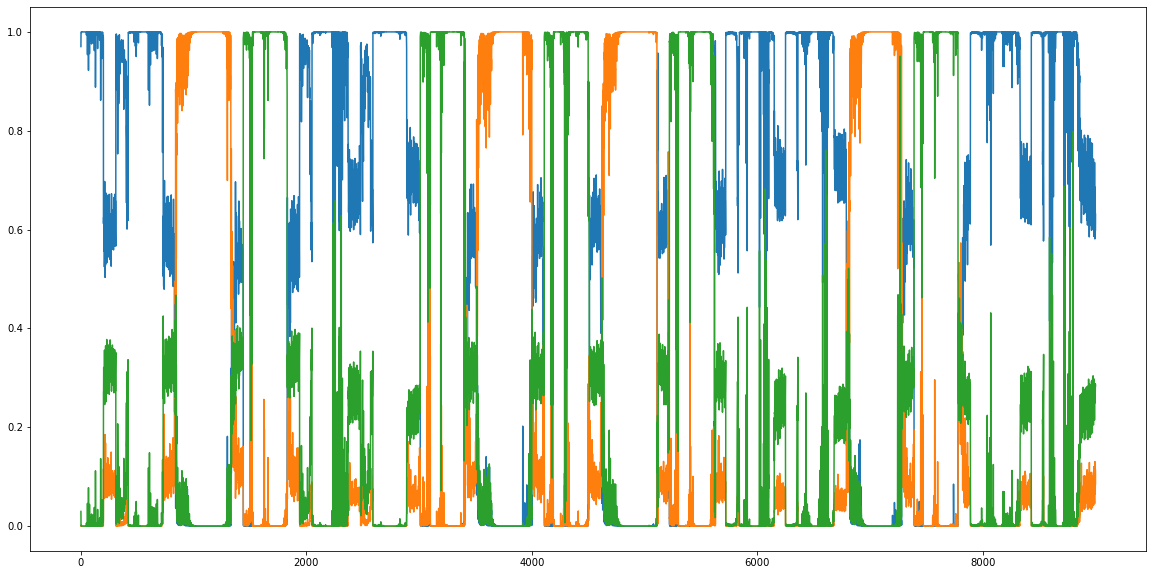

In [49]:
plt.figure(figsize=(20, 10))
plt.plot(preds_test.reshape(-1, 3))

# Venga con los embeddings de los...

In [ ]:
datas = data.reshape((data.shape[0], -1))
datas = standardize(datas, 1)
ts = np.argmax(np.mean(target, axis=1), axis=1)

embedding = reducer.fit_transform(datas)
plt.figure(figsize=(20, 20))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=20, c=ts, alpha=1)
plt.gca().set_aspect('equal', 'datalim')
plt.title(v, fontsize=24)